<a href="https://colab.research.google.com/github/danjor667/data_processing_formative2/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

In [3]:
transactions = pd.read_csv("customer_transactions.csv")
transactions.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


In [4]:
transactions.describe()

,customer_id_legacy,transaction_id,purchase_amount,customer_rating
count,150.000000,150.000000,150.000000,140.00000
mean,148.760000,1075.500000,280.780000,2.98500
std,30.046425,43.445368,121.329595,1.20699
min,100.000000,1001.000000,51.000000,1.00000
25%,121.250000,1038.250000,179.000000,1.95000
50%,150.500000,1075.500000,274.000000,3.00000
75%,174.750000,1112.750000,388.500000,4.00000
max,199.000000,1150.000000,495.000000,5.00000


In [5]:
transactions.isnull().sum()

,0
customer_id_legacy,0
transaction_id,0
purchase_amount,0
purchase_date,0
product_category,0
customer_rating,10


In [ ]:
# filling missing values with the mean of the column

In [6]:
average_rating = transactions["customer_rating"].mean()
transactions.fillna(average_rating, inplace=True)
transactions.describe()

,customer_id_legacy,transaction_id,purchase_amount,customer_rating
count,150.000000,150.000000,150.000000,150.000000
mean,148.760000,1075.500000,280.780000,2.985000
std,30.046425,43.445368,121.329595,1.165783
min,100.000000,1001.000000,51.000000,1.000000
25%,121.250000,1038.250000,179.000000,2.100000
50%,150.500000,1075.500000,274.000000,2.985000
75%,174.750000,1112.750000,388.500000,4.000000
max,199.000000,1150.000000,495.000000,5.000000


In [ ]:
# Apply log transformation to skewed data. (the puchase amount column)

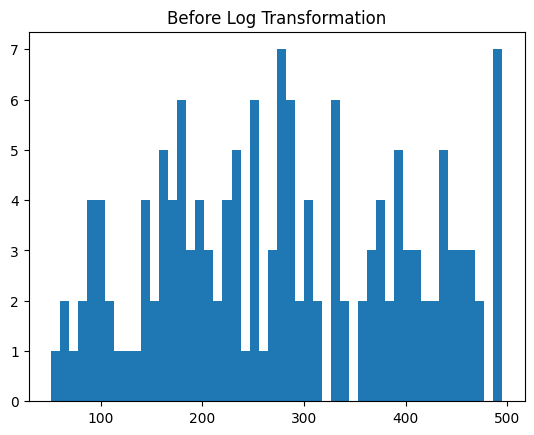

Skewness before: 0.05904654489479159


In [7]:

# Histogram before transformation
plt.hist(transactions['purchase_amount'], bins=50)
plt.title('Before Log Transformation')
plt.show()

# Check skewness
print("Skewness before:", transactions['purchase_amount'].skew())

transactions['purchase_amount_log'] = np.log1p(transactions['purchase_amount'])



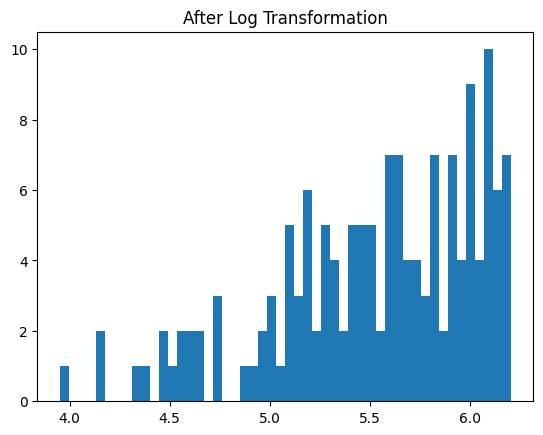

Skewness after: -0.8061226889979501


In [8]:
plt.hist(transactions['purchase_amount_log'], bins=50)
plt.title('After Log Transformation')
plt.show()

print("Skewness after:", transactions['purchase_amount_log'].skew())


In [9]:
# since the absolute value of the screwness in the origial data is closer to zero that that of the transformed data, we can say that the transformation was not necessary. so droping the transformed column (purchase_amount_log)

transactions.drop('purchase_amount_log', axis=1, inplace=True)

In [10]:
# synthetic data Generation
transactions.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


In [11]:

# Convert date column to datetime format
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

# Select relevant numerical features for clustering
features = transactions[['purchase_amount', 'customer_rating']].copy()


# Apply K-Means clustering to group customers based on behavior
num_clusters = 5  # Can be tuned
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
transactions['cluster'] = kmeans.fit_predict(features)


In [12]:
def generate_synthetic_transaction(row):
    cluster_id = row['cluster']

    # Get cluster-specific transaction patterns
    cluster_data = transactions[transactions['cluster'] == cluster_id]

    if cluster_data.empty:
        return pd.Series({'purchase_amount': row['purchase_amount'],
                          'purchase_date': row['purchase_date'],
                          'product_category': row['product_category']})

    # Generate synthetic transaction values with noise
    new_value = np.random.normal(cluster_data['purchase_amount'].mean(),
                                 cluster_data['purchase_amount'].std())
    new_value = max(0, new_value)  # Ensure non-negative values

    # Shift purchase date within a similar timeframe
    date_offset = np.random.randint(-30, 30)  # Random shift within ±30 days
    new_date = row['purchase_date'] + timedelta(days=date_offset)

    # Sample product category based on distribution within the same cluster
    category_probs = cluster_data['product_category'].value_counts(normalize=True)
    new_category = np.random.choice(category_probs.index, p=category_probs.values)

    return pd.Series({'purchase_amount': new_value,
                      'purchase_date': new_date,
                      'product_category': new_category})

In [13]:
# Apply the function to create synthetic data
df_synthetic = transactions.copy()
df_synthetic[['purchase_amount', 'purchase_date', 'product_category']] = df_synthetic.apply(generate_synthetic_transaction, axis=1)

# Generate unique synthetic transaction IDs increments of 1
df_synthetic['transaction_id'] = transactions['transaction_id'].max() + np.arange(1, len(df_synthetic) + 1)


# Save synthetic dataset
df_synthetic.to_csv("synthetic_dataset.csv", index=False)

# Display sample
df_synthetic.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,cluster
0,151,1151,335.822392,2024-01-07,Groceries,2.3,4
1,192,1152,378.666833,2023-12-27,Sports,4.2,4
2,114,1153,466.034574,2023-12-09,Sports,2.1,1
3,171,1154,291.401856,2024-01-07,Groceries,2.8,0
4,160,1155,64.995225,2023-12-23,Sports,1.3,2


In [14]:
# merging both data and saving it

augmented_df= pd.concat([transactions, df_synthetic], ignore_index=True)

#dropping the cluster column

augmented_df.drop('cluster', axis=1, inplace=True)

augmented_df.to_csv("customer_transactions_augmented.csv", index=False)


In [ ]:
# Part 2: Merging Datasets with Transitive Properties


In [16]:
id_mapping = pd.read_csv("id_mapping.csv")
social_profile = pd.read_csv("customer_social_profiles.csv")
augmented_data = pd.read_csv("customer_transactions_augmented.csv")


id_mapping_filtered = id_mapping.drop_duplicates(subset=["customer_id_legacy"], keep="first")

result = transactions.merge(id_mapping_filtered,  on="customer_id_legacy",  how="left")

df_final = result.merge(social_profile,  on="customer_id_new",  how="left")


df_final.head()




,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,cluster,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,151,1001,408,2024-01-01,Sports,2.3,4,A176,Facebook,70.0,3.3,Negative
1,192,1002,332,2024-01-02,Electronics,4.2,4,A156,Instagram,52.0,4.9,Positive
2,114,1003,442,2024-01-03,Electronics,2.1,1,A171,NaN,NaN,NaN,NaN
3,171,1004,256,2024-01-04,Clothing,2.8,0,NaN,NaN,NaN,NaN,NaN
4,160,1005,64,2024-01-05,Clothing,1.3,2,NaN,NaN,NaN,NaN,NaN


In [17]:
df_final['sentiment_numeric'] = df_final['review_sentiment'].map({'positive': 1, 'negative': 0})

df_final['normalized_sm_engagement'] = 100 * (df_final['engagement_score'] - df_final['engagement_score'].min()) / (df_final['engagement_score'].max() - df_final['engagement_score'].min())

# Weight based on recency of purchases
df_final['purchase_date'] = pd.to_datetime(df_final['purchase_date'])
df_final['days_since_purchase'] = (pd.to_datetime('today') - df_final['purchase_date']).dt.days
df_final['recency_weight'] = 1 / (1 + np.log1p(df_final['days_since_purchase']))

# Use purchase amount as a factor
df_final['purchase_amount_normalized'] = 100 * (df_final['purchase_amount'] - df_final['purchase_amount'].min()) / (df_final['purchase_amount'].max() - df_final['purchase_amount'].min())

# Create composite engagement score
df_final['customer_engagement_score'] = (
    0.3 * df_final['normalized_sm_engagement'] +
    0.3 * df_final['purchase_amount_normalized'] * df_final['recency_weight'] +
    0.2 * df_final['purchase_interest_score'] +
    0.2 * df_final['sentiment_numeric'] * 100
)

# 2. Moving Averages of Transactions
df_final = df_final.sort_values(['customer_id_new', 'purchase_date'])

# Group by customer and calculate moving averages
customer_txn = df_final.groupby('customer_id_new')['purchase_amount']

# 3-purchase moving average
df_final['ma_3_purchases'] = customer_txn.transform(lambda x: x.rolling(3, min_periods=1).mean())

# 6-purchase moving average
df_final['ma_6_purchases'] = customer_txn.transform(lambda x: x.rolling(6, min_periods=1).mean())

# 3. Time-based Aggregation of Purchases
# Extract time components
df_final['purchase_month'] = df_final['purchase_date'].dt.month
df_final['purchase_day_of_week'] = df_final['purchase_date'].dt.dayofweek
df_final['purchase_hour'] = df_final['purchase_date'].dt.hour

# Time since previous purchase (by customer)
df_final['days_since_prev_purchase'] = df_final.groupby('customer_id_new')['purchase_date'].diff().dt.days

# Purchase frequency (purchases per month)
purchase_counts = df_final.groupby(['customer_id_new', df_final['purchase_date'].dt.to_period('M')]).size().reset_index(name='monthly_purchase_count')
monthly_avg = purchase_counts.groupby('customer_id_new')['monthly_purchase_count'].mean().reset_index(name='avg_monthly_purchases')
df_final = df_final.merge(monthly_avg, on='customer_id_new', how='left')

# Seasonal purchase patterns
df_final['purchase_quarter'] = df_final['purchase_date'].dt.quarter
quarter_spend = df_final.groupby(['customer_id_new', 'purchase_quarter'])['purchase_amount'].mean().unstack().fillna(0)
for q in range(1, 5):
    if q in quarter_spend.columns:
        df_final = df_final.merge(quarter_spend[q].rename(f'avg_q{q}_spend').reset_index(), on='customer_id_new', how='left')

# 4. Category Engagement Features
# Calculate category preferences
category_counts = df_final.groupby(['customer_id_new', 'product_category']).size().reset_index(name='category_purchase_count')
total_purchases = category_counts.groupby('customer_id_new')['category_purchase_count'].sum().reset_index(name='total_purchases')
category_counts = category_counts.merge(total_purchases, on='customer_id_new')
category_counts['category_preference'] = category_counts['category_purchase_count'] / category_counts['total_purchases']

# Get top category for each customer
top_categories = category_counts.sort_values(['customer_id_new', 'category_preference'], ascending=[True, False])
top_categories = top_categories.groupby('customer_id_new').first().reset_index()[['customer_id_new', 'product_category']]
top_categories.rename(columns={'product_category': 'preferred_category'}, inplace=True)

# Merge back to original dataframe
df_final = df_final.merge(top_categories, on='customer_id_new', how='left')

# 5. Social Media Platform Engagement
# Create dummy variables for social media platforms
sm_dummies = pd.get_dummies(df_final['social_media_platform'], prefix='sm')
df_final = pd.concat([df_final, sm_dummies], axis=1)

# Calculate platform-specific engagement
for platform in df_final['social_media_platform'].unique():
    mask = df_final['social_media_platform'] == platform
    df_final.loc[mask, f'{platform}_engagement'] = df_final.loc[mask, 'engagement_score']

In [18]:
df_final.head()

# saving the data

df_final.to_csv("final_customer_data_[Databases-Peer-2].csv")

## TASK 3: Data Consistency and Quality Checks

In [19]:
import pandas as pd

# Load dataset
df = pd.read_csv("final_customer_data_[Databases-Peer-2].csv")

# Display dataset information
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  233 non-null    int64  
 1   customer_id_legacy          233 non-null    int64  
 2   transaction_id              233 non-null    int64  
 3   purchase_amount             233 non-null    int64  
 4   purchase_date               233 non-null    object 
 5   product_category            233 non-null    object 
 6   customer_rating             233 non-null    float64
 7   cluster                     233 non-null    int64  
 8   customer_id_new             202 non-null    object 
 9   social_media_platform       180 non-null    object 
 10  engagement_score            180 non-null    float64
 11  purchase_interest_score     180 non-null    float64
 12  review_sentiment            180 non-null    object 
 13  sentiment_numeric           0 non-n

,Unnamed: 0,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,cluster,customer_id_new,social_media_platform,...,sm_Instagram,sm_LinkedIn,sm_TikTok,sm_Twitter,LinkedIn_engagement,Twitter_engagement,Facebook_engagement,nan_engagement,Instagram_engagement,TikTok_engagement
0,0,106,1047,397,2024-02-16,Sports,1.7,4,A102,LinkedIn,...,False,True,False,False,51.0,NaN,NaN,NaN,NaN,NaN
1,1,106,1126,250,2024-05-05,Clothing,3.5,0,A102,LinkedIn,...,False,True,False,False,51.0,NaN,NaN,NaN,NaN,NaN
2,2,141,1033,219,2024-02-02,Groceries,1.4,3,A107,Twitter,...,False,False,False,True,NaN,96.0,NaN,NaN,NaN,NaN
3,3,141,1033,219,2024-02-02,Groceries,1.4,3,A107,Facebook,...,False,False,False,False,NaN,NaN,62.0,NaN,NaN,NaN
4,4,141,1033,219,2024-02-02,Groceries,1.4,3,A107,Twitter,...,False,False,False,True,NaN,73.0,NaN,NaN,NaN,NaN


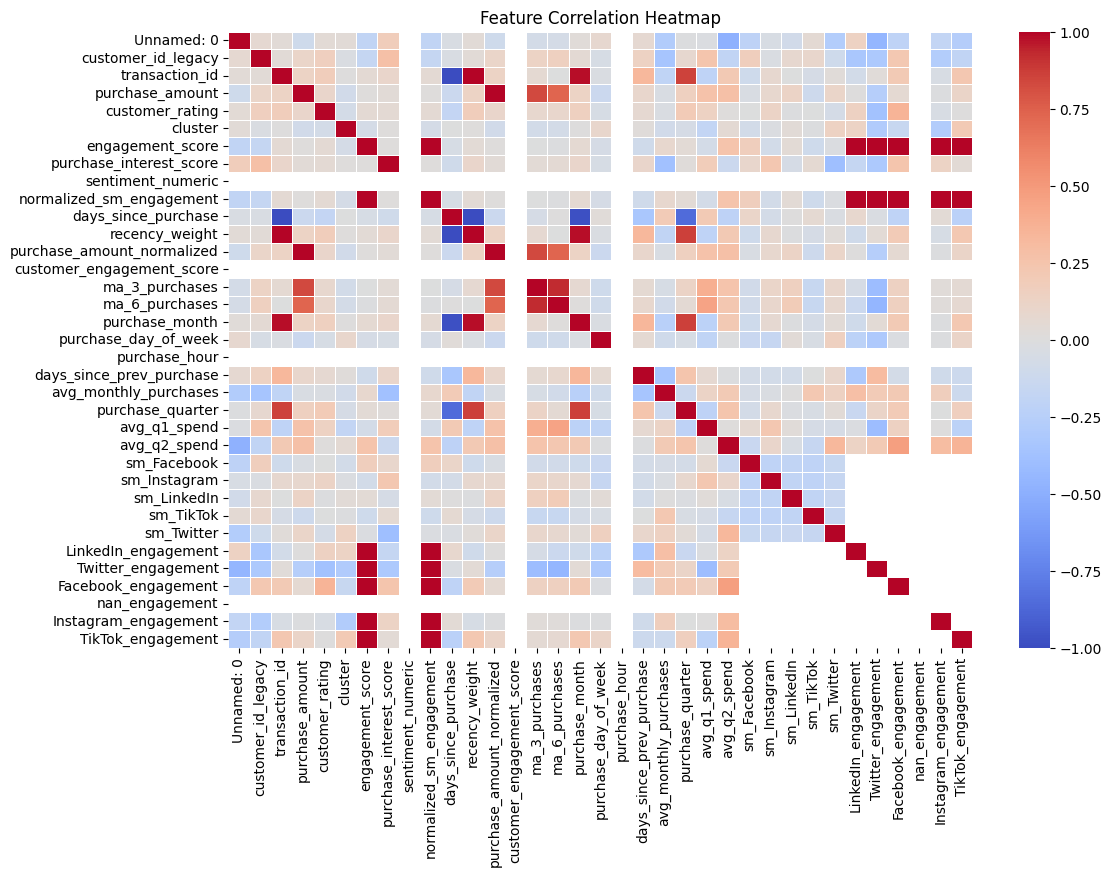

In [20]:
import seaborn as sns

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()


In [21]:
import numpy as np

# Droping non-numeric columns and target variable
df_numeric = df.select_dtypes(include=[np.number]).drop(columns=['Unnamed: 0', 'customer_id_legacy', 'transaction_id'])
df_numeric = df_numeric.dropna(axis=1, thresh=0.7 * len(df_numeric))

# Fill remaining missing values with column mean
df_numeric = df_numeric.fillna(df_numeric.mean())


In [22]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define features and target
X = df_numeric.drop(columns=['customer_rating'])  # Features
y = df_numeric['customer_rating']  # Target variable

# Apply SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]

# Display selected features
print("Top 10 Selected Features:", selected_features)


Top 10 Selected Features: Index(['cluster', 'days_since_purchase', 'recency_weight',
       'purchase_amount_normalized', 'ma_3_purchases', 'ma_6_purchases',
       'purchase_month', 'purchase_day_of_week', 'avg_monthly_purchases',
       'avg_q2_spend'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [23]:
final_df = df_numeric[selected_features]

# Save to CSV
final_df.to_csv("final_dataset_ready_peer2.csv", index=False)
final_df.head()


,cluster,days_since_purchase,recency_weight,purchase_amount_normalized,ma_3_purchases,ma_6_purchases,purchase_month,purchase_day_of_week,avg_monthly_purchases,avg_q2_spend
0,4,394,0.143289,77.927928,397.0,397.0,2,4,1.0,250.0
1,0,315,0.148022,44.819820,323.5,323.5,5,6,1.0,250.0
2,3,408,0.142578,37.837838,219.0,219.0,2,4,3.0,452.0
3,3,408,0.142578,37.837838,219.0,219.0,2,4,3.0,452.0
4,3,408,0.142578,37.837838,219.0,219.0,2,4,3.0,452.0
